# Preparing the Enviorment




## Intsall Essential Packaeges

In [ ]:
!pip install tacoreader rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 104.9 MB/s eta 0:00:00


## Imports

In [ ]:
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import v2

In [ ]:
from PIL import Image
import tacoreader
from tacoreader import TortillaDataFrame
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import multiprocessing
from tqdm import tqdm
import os
from typing import List, Dict, Callable, Union

## Paths and Directories

In [1]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
ROOT_PATH = Path('/content/drive/MyDrive/datasets/sen2venus')

TACO_RAW_DIR = ROOT_PATH / 'TACO_raw_data'
os.makedirs(TACO_RAW_DIR, exist_ok=True)
print(f"Data will be saved to: {TACO_RAW_DIR}")

SELECTED_SUBSETS = [
    "SUDOUE-4",
    "SUDOUE-5",
    "SUDOUE-6"
]
TACO_FILE_PATHS = [TACO_RAW_DIR / f"{site_name}.taco" for site_name in SELECTED_SUBSETS]


NORMALIZED_SETS_DIR = ROOT_PATH / 'normalized_sets'
os.makedirs(NORMALIZED_SETS_DIR, exist_ok=True)
print(f"Normalaized datest will be saved to: {NORMALIZED_SETS_DIR}")

TRAIN_SAVE_DIR = NORMALIZED_SETS_DIR / 'train'
os.makedirs(TRAIN_SAVE_DIR, exist_ok=True)
print(f"Train data will be saved to: {TRAIN_SAVE_DIR}")

VAL_SAVE_DIR = NORMALIZED_SETS_DIR / 'val'
os.makedirs(VAL_SAVE_DIR, exist_ok=True)
print(f"Validation data will be saved to: {VAL_SAVE_DIR}")

TEST_SAVE_DIR = NORMALIZED_SETS_DIR / 'test'
os.makedirs(TEST_SAVE_DIR, exist_ok=True)
print(f"Test data will be saved to: {TEST_SAVE_DIR}")

Data will be saved to: /content/drive/MyDrive/datasets/sen2venus/TACO_raw_data
Normalaized datest will be saved to: /content/drive/MyDrive/datasets/sen2venus/normalized_sets
Train data will be saved to: /content/drive/MyDrive/datasets/sen2venus/normalized_sets/train
Validation data will be saved to: /content/drive/MyDrive/datasets/sen2venus/normalized_sets/val
Test data will be saved to: /content/drive/MyDrive/datasets/sen2venus/normalized_sets/test


# EDA

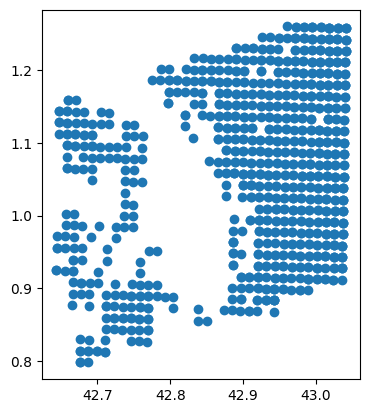

In [ ]:
dataset = tacoreader.load("tacofoundation:sen2venus")

# Filter the dataset for the SUDOUE-x region
site_df = dataset[dataset["region"] == 'SUDOUE-4']

# Extract the year from the timestamp
# years = pd.to_datetime(site_df["stac:time_start"], unit='s').dt.year

# Subset the dataframe for the year 2019
# subset_final = site_df[years == 2019]

# Plot the subset
site_df.plot()


In [ ]:
site_df.info()

<class 'tacoreader.TortillaDataFrame.TortillaDataFrame'>
Index: 935 entries, 56574 to 56103
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   internal:subfile      935 non-null    object 
 1   tortilla:id           935 non-null    object 
 2   tortilla:file_format  935 non-null    object 
 3   tortilla:data_split   935 non-null    object 
 4   tortilla:offset       935 non-null    int64  
 5   tortilla:length       935 non-null    int64  
 6   stac:crs              935 non-null    object 
 7   stac:geotransform     935 non-null    object 
 8   stac:raster_shape     935 non-null    object 
 9   stac:time_start       935 non-null    float64
 10  stac:time_end         935 non-null    float64
 11  stac:centroid         935 non-null    object 
 12  rai:ele               935 non-null    int64  
 13  rai:cisi              935 non-null    int64  
 14  rai:gdp               935 non-null    int64  
 15  rai

In [ ]:
site_df.head(n=5)

,internal:subfile,tortilla:id,tortilla:file_format,tortilla:data_split,tortilla:offset,tortilla:length,stac:crs,stac:geotransform,stac:raster_shape,stac:time_start,...,rai:pop,rai:admin0,rai:admin1,rai:admin2,region,s2_tile,patch_n_id,days_between,scale_factor,venus_zenith_angle
56574,"/vsisubfile/7674419379_803800,/vsicurl/https:/...",SUDOUE-4_0_2019-07-05_31TCH,TORTILLA,train,7674419379,803800,EPSG:32631,"[347165.0, 5.0, 0.0, 4750840.0, 0.0, -5.0]","[256, 256]",1.562278e+09,...,0,missing,missing,missing,SUDOUE-4,31TCH,0,0,2,29.516127
56475,"/vsisubfile/7592553490_849771,/vsicurl/https:/...",SUDOUE-4_0_2019-09-13_31TCH,TORTILLA,train,7592553490,849771,EPSG:32631,"[333085.0, 5.0, 0.0, 4766200.0, 0.0, -5.0]","[256, 256]",1.568326e+09,...,0,missing,missing,missing,SUDOUE-4,31TCH,0,0,2,29.516127
55919,"/vsisubfile/7131275113_871207,/vsicurl/https:/...",SUDOUE-4_0_2020-01-01_31TCH,TORTILLA,train,7131275113,871207,EPSG:32631,"[333085.0, 5.0, 0.0, 4750840.0, 0.0, -5.0]","[256, 256]",1.577833e+09,...,0,missing,missing,missing,SUDOUE-4,31TCH,0,0,2,29.516127
56237,"/vsisubfile/7394818757_858089,/vsicurl/https:/...",SUDOUE-4_0_2020-03-01_31TCH,TORTILLA,train,7394818757,858089,EPSG:32631,"[340765.0, 5.0, 0.0, 4754680.0, 0.0, -5.0]","[256, 256]",1.583017e+09,...,0,missing,missing,missing,SUDOUE-4,31TCH,0,0,2,29.516127
56187,"/vsisubfile/7353106410_824581,/vsicurl/https:/...",SUDOUE-4_0_2020-03-21_31TCH,TORTILLA,train,7353106410,824581,EPSG:32631,"[340765.0, 5.0, 0.0, 4725240.0, 0.0, -5.0]","[256, 256]",1.584745e+09,...,0,missing,missing,missing,SUDOUE-4,31TCH,0,0,2,29.516127


In [ ]:
print(f"Number of patches: {len(site_df)}")

Number of patches: 935


In [ ]:
# Read a sample row
sample_idx = 1 # Until len(site_df
row: TortillaDataFrame = site_df.read(sample_idx)
row_id = site_df.iloc[sample_idx]["tortilla:id"]

# Retrieve the data
lr, hr = row.read(0), row.read(1)
with rio.open(lr) as src_lr, rio.open(hr) as src_hr:
    lr_data = src_lr.read([1, 2, 3]) # Blue, Green, Red of Sentinel-2
    hr_data = src_hr.read([1, 2, 3]) # Blue, Green, Red of Neon



In [ ]:
print(type(src_lr))
print('---')
print(src_lr.meta)
print('---')
print(src_lr.count)
print('---')
print(src_lr.indexes)

<class 'rasterio.io.DatasetReader'>
---
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 128, 'height': 128, 'count': 10, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(10.0, 0.0, 333085.0,
       0.0, -10.0, 4766200.0)}
---
10
---
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


In [ ]:
print(type(row))
print('------')
print(row.columns)
print('------')
print(row)
print('------')
print(row['internal:subfile'])
print('------')
print(row['tortilla:id'])

<class 'tacoreader.TortillaDataFrame.TortillaDataFrame'>
------
Index(['internal:subfile', 'tortilla:id', 'tortilla:file_format',
       'tortilla:data_split', 'tortilla:offset', 'tortilla:length', 'stac:crs',
       'stac:geotransform', 'stac:raster_shape', 'stac:time_start',
       'stac:time_end', 'stac:centroid', 'region', 's2_tile', 'patch_n_id',
       'negative_values'],
      dtype='object')
------
                                    internal:subfile tortilla:id  \
0  /vsisubfile/7592553690_141138,/vsicurl/https:/...          lr   
1  /vsisubfile/7592694828_698213,/vsicurl/https:/...          hr   

  tortilla:file_format tortilla:data_split  tortilla:offset  tortilla:length  \
0                GTiff               train       7592553690           141138   
1                GTiff               train       7592694828           698213   

     stac:crs                             stac:geotransform stac:raster_shape  \
0  EPSG:32631  [333085.0, 10.0, 0.0, 4766200.0, 0.0, -10.0]    

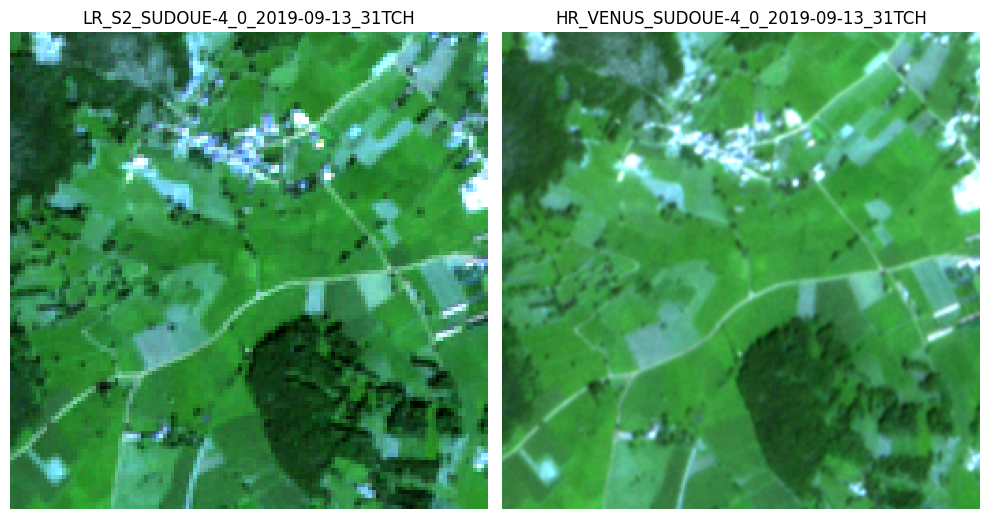

In [ ]:
# Display
fig, ax = plt.subplots(1, 2, figsize=(10, 5.5))
ax[0].imshow(lr_data.transpose(1, 2, 0) / 1000)
ax[0].set_title(f'LR_S2_{row_id}')
ax[0].axis('off')
ax[1].imshow(hr_data.transpose(1, 2, 0) / 1000)
ax[1].set_title(f'HR_VENUS_{row_id}')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(lr_data.shape)
print(hr_data.shape)

print('lr min pixel val: ', lr_data.min())
print('lr max pixel val: ', lr_data.max())
print('hr min pixel val: ', hr_data.min())
print('hr max pixel val: ', hr_data.max())

print(lr_data.dtype)

# print(lr_data.transpose(1, 2, 0))
print(type(lr_data.transpose(1, 2, 0)))
print(type(lr_data.transpose(1, 2, 0)))
print(type(Image.fromarray(lr_data.transpose(1, 2, 0).astype(np.float32))))

(3, 128, 128)
(3, 256, 256)
lr min pixel val:  0
lr max pixel val:  3149
hr min pixel val:  6
hr max pixel val:  2769
uint16
<class 'numpy.ndarray'>
<attribute 'dtype' of 'numpy.ndarray' objects>


TypeError: Cannot handle this data type: (1, 1, 3), <f4

## Compile the Selected subets

In [ ]:
# Compile the filtered data into "mini.taco" using 8 workers

OUTPUT_FILE = TACO_RAW_DIR / "SUDOUE-4.taco"
tacoreader.compile(dataframe=site_df, output=OUTPUT_FILE, nworkers=8)

# Load the compiled data
# minitaco = tacoreader.load(OUTPUT_FILE)

Cooking a tortilla: 100%|██████████| 935/935 [00:45<00:00, 20.38file/s]


PosixPath('/content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-4.taco')

# Step 1: Download the Selected Regions (one time only)

In [ ]:
SELECTED_SUBSETS = [
    # "SUDOUE-4",
    "SUDOUE-5",
    "SUDOUE-6"
]


def get_taco_subset(site_name: str)->TortillaDataFrame:
  dataset = tacoreader.load("tacofoundation:sen2venus")

  # The 'region' column holds the site name, e.g., 'SUDOUE-4'
  site_df = dataset[dataset["region"] == site_name]

  if len(site_df) == 0:
    raise ValueError(f'invalid site name {site_name}')

  return site_df


def compile_save_subset(output_filename: str| Path, site_df: TortillaDataFrame)->None:
  print(f"Compiling {len(site_df)} patches into {output_filename}...")
  tacoreader.compile(dataframe=site_df, output=output_filename, nworkers=8)


def get_compile_subsets(site_names : List[str])->None:
  for site_name in site_names:
    print(f"\nProcessing site: {site_name}")
    site_df = get_taco_subset(site_name)
    output_filename = TACO_RAW_DIR / f"{site_name}.taco"
    compile_save_subset(output_filename, site_df)


In [ ]:
get_compile_subsets(SELECTED_SUBSETS)


Processing site: SUDOUE-5
Compiling 2176 patches into /content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-5.taco...


Rolling out a tortilla: 100%|██████████| 2176/2176 [02:20<00:00, 15.48file/s]



Processing site: SUDOUE-6
Compiling 2435 patches into /content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-6.taco...


Grilling a tortilla 🫓: 100%|██████████| 2435/2435 [02:46<00:00, 14.62file/s]


# Step 2: Define PyTorch Datasets

In [ ]:
class TACORGBDataset(Dataset):
    """
    Custom Dataset for reading compiled .taco files.
    """

    def __init__(
        self,
        taco_file_paths: List[str | Path],
        transform: Callable = None,
        lr_band_combo: List[int] = [1, 2, 3], # Blue, Green, Red of Sentinel-2
        hr_band_combo: List[int] = [1, 2, 3], # Blue, Green, Red of venus
    ):
        """
        Args:
            taco_file_paths (List[str]): A list of file paths to the .taco files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.taco_files = [str(p) for p in taco_file_paths]
        self.transform = transform
        self.lr_band_combo = lr_band_combo
        self.hr_band_combo = hr_band_combo

        # Load and concatenate all specified .taco files into a single dataframe
        print(f"Loading data from: {self.taco_files}")
        # Convert PosixPath objects to strings
        list_of_dfs = [tacoreader.load(p) for p in self.taco_files]
        self.dataframe = pd.concat(list_of_dfs, ignore_index=True)
        print(f"Successfully loaded a total of {len(self.dataframe)} samples.")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the data for one row from the dataframe
        row = self.dataframe.read(idx)

        # Retrieve the data
        lr, hr = row.read(0), row.read(1)
        with rio.open(lr) as src_lr, rio.open(hr) as src_hr:
            lr_image_np = src_lr.read(self.lr_band_combo) 
            hr_image_np = src_hr.read(self.hr_band_combo)  

        # Convert directly to PyTorch Tensors. This preserves the uint16 data.
        lr_tensor = torch.from_numpy(lr_image_np)
        hr_tensor = torch.from_numpy(hr_image_np)

        lr_tensor = lr_tensor.float()
        hr_tensor = hr_tensor.float()

        sample = {"lr": lr_tensor, "hr": hr_tensor}

        if self.transform:
            sample = self.transform(sample)

        return sample


class NormalizedTacoDataset(Dataset):
    """
    Custom Wrapper Datasetclass for applying normalization
    on Tran/Test/Validation subsets.
    """

    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # Gets the raw tensor from the subset
        sample = self.subset[index]
        # Applies the final normalization transform
        return self.transform(sample)

    def __len__(self):
        return len(self.subset)


class PreNormalizedDataset(Dataset):
    """
    An efficient Dataset that reads pre-processed, sharded tensor files.
    """

    def __init__(self, shard_dir: Union[str, Path]):
        """
        Args:
            shard_dir (Union[str, Path]): The directory containing the shard files.
        """
        # Immediately convert the input to a Path object to standardize its type.
        self.shard_dir = Path(shard_dir)

        # Use the object-oriented .glob() method to find all .pt files.
        # It returns a generator, so we convert to a list before sorting.
        self.shard_paths: List[Path] = sorted(self.shard_dir.glob("*.pt"))

        if not self.shard_paths:
            raise ValueError(f"No shard files ('*.pt') found in {self.shard_dir}")

        # The rest of the logic remains the same, but is more robust
        # because torch.load() works seamlessly with Path objects.

        # Load the first shard to determine the shard_size
        first_shard = torch.load(self.shard_paths[0])
        self.shard_size = len(first_shard)

        # Load the last shard to calculate the total length accurately
        last_shard = torch.load(self.shard_paths[-1])
        self.length = (len(self.shard_paths) - 1) * self.shard_size + len(last_shard)

        # A simple cache to hold the most recently used shard
        self._cache = {}
        # A variable to keep track of which shard is currently in the cache
        self._cached_shard_index = -1

        print(
            f"Initialized dataset from {self.shard_dir} with {self.length} samples across {len(self.shard_paths)} shards."
        )

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        shard_index = idx // self.shard_size
        index_in_shard = idx % self.shard_size

        # Check if the required shard is currently cached
        if shard_index != self._cached_shard_index:
            # If not, load the correct shard from disk and update the cache
            shard_path = self.shard_paths[shard_index]
            self._cache = torch.load(shard_path)
            self._cached_shard_index = shard_index

        # coupled with TACORGBDataset dataset class
        # each item in the shard is a squeezed dictionary with keys lr and hr
        squeezed_sample = self._cache[index_in_shard]
        return squeezed_sample["lr"], squeezed_sample["hr"]


In [ ]:
full_dataset = TACORGBDataset(taco_file_paths=TACO_FILE_PATHS)

Loading data from: ['/content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-4.taco', '/content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-5.taco', '/content/drive/MyDrive/datasets/sen2venus/TACO_raw_data/SUDOUE-6.taco']
Successfully loaded a total of 5546 samples.


In [ ]:
first_item = full_dataset[101]
print(f"LR image tensor shape: {first_item['lr'].shape}")
print(f"HR image tensor shape: {first_item['hr'].shape}")

LR image tensor shape: torch.Size([3, 128, 128])
HR image tensor shape: torch.Size([3, 256, 256])


# Step 3: Split the Dataset

In [ ]:
# Define split sizes
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Perform the split
train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Train samples: {len(train_subset)}, Validation samples: {len(val_subset)}, Test samples: {len(test_subset)}")

Train samples: 4436, Validation samples: 554, Test samples: 556


# Step 4: Confirm the Preprocessing

> Several preprocessing steps have already been applied to the dataset by `TACO foundation`:

- **Handling of negative pixel values:** Some Sentinel-2 images contained negative pixel values, which have been masked to **0**.
- **No-data values:** All no-data values are now set to **65525** for consistency.
- **Data type conversion:** The original dataset was stored in **int16**, and it has been converted to **uint16** for storage and processing.

# Step 5: Statistical Analysis

In [ ]:
def get_subset_stats(loader: DataLoader):
    """
    Calculates statistics by iterating through a DataLoader, processing one batch at a time.
    This is significantly more efficient than loading all samples into memory first.
    """

    # Initialize trackers for the statistics we need
    # For min/max, we can track the running value.
    # For mean/std, the correct way to aggregate across batches is to track sums.

    # Initialize min/max trackers for 3 channels (R, G, B)
    lr_max = torch.tensor([-float('inf')] * 3)
    hr_max = torch.tensor([-float('inf')] * 3)
    lr_min = torch.tensor([float('inf')] * 3)
    hr_min = torch.tensor([float('inf')] * 3)

    # Trackers for a numerically stable standard deviation calculation
    lr_sum = torch.zeros(3)
    hr_sum = torch.zeros(3)
    lr_sum_sq = torch.zeros(3)
    hr_sum_sq = torch.zeros(3)
    pixel_count = 0

    # Iterate through the batches provided by the DataLoader
    for batch in tqdm(loader, desc="Calculating Stats"):
        lr_batch = batch['lr'] # Shape: (B, C, H, W) e.g., (64, 3, 128, 128)
        hr_batch = batch['hr']

        # --- Min/Max Calculation (Batch-wise) ---
        # Find the max value along all dims except the channel dim
        current_lr_max = torch.amax(lr_batch, dim=(0, 2, 3))
        current_hr_max = torch.amax(hr_batch, dim=(0, 2, 3))
        # Update our running global max
        lr_max = torch.maximum(lr_max, current_lr_max)
        hr_max = torch.maximum(hr_max, current_hr_max)

        # Do the same for min
        current_lr_min = torch.amin(lr_batch, dim=(0, 2, 3))
        current_hr_min = torch.amin(hr_batch, dim=(0, 2, 3))
        lr_min = torch.minimum(lr_min, current_lr_min)
        hr_min = torch.minimum(hr_min, current_hr_min)

        # --- Mean/Std Calculation (Batch-wise) ---
        # Sum up all values per channel for this batch
        lr_sum += torch.sum(lr_batch, dim=(0, 2, 3))
        hr_sum += torch.sum(hr_batch, dim=(0, 2, 3))
        # Sum up the squares of all values per channel
        lr_sum_sq += torch.sum(lr_batch**2, dim=(0, 2, 3))
        hr_sum_sq += torch.sum(hr_batch**2, dim=(0, 2, 3))

        # Count the total number of pixels per channel
        # Batch size * height * width
        pixel_count += lr_batch.shape[0] * lr_batch.shape[2] * lr_batch.shape[3]

    # Finalize the mean and standard deviation calculations
    mean_lr = lr_sum / pixel_count
    mean_hr = hr_sum / pixel_count

    # std_lr = torch.sqrt((lr_sum_sq / pixel_count) - mean_lr**2)
    # std_hr = torch.sqrt((hr_sum_sq / pixel_count) - mean_hr**2)

    # Inside get_stats_efficiently, before the return statement:
    variance_lr = (lr_sum_sq / pixel_count) - mean_lr**2
    variance_hr = (hr_sum_sq / pixel_count) - mean_hr**2

    # Clamp the variance at 0 to prevent negative values from causing nans in the sqrt.
    std_lr = torch.sqrt(torch.clamp(variance_lr, min=0))
    std_hr = torch.sqrt(torch.clamp(variance_hr, min=0))

    # Compile results into a dictionary
    stats = {
        'lr_max_per_channel': lr_max,
        'hr_max_per_channel': hr_max,
        'lr_min_per_channel': lr_min,
        'hr_min_per_channel': hr_min,
        'lr_mean_per_channel': mean_lr,
        'hr_mean_per_channel': mean_hr,
        'lr_std_per_channel': std_lr,
        'hr_std_per_channel': std_hr,
    }

    return stats

## Dataloaders

In [ ]:
num_workers = 2
batch_size = 64

### Train Stats

In [ ]:
train_stats_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False  # No need to shuffle for statistical analysis
)

train_stats = get_subset_stats(train_stats_loader)

print("\n--- Calculated Statistics ---")
for key, value in train_stats.items():
    print(f"{key}: {value.tolist()}")

Calculating Stats: 100%|██████████| 70/70 [08:02<00:00,  6.90s/it]


--- Calculated Statistics ---
lr_max_per_channel: [8683.0, 9235.0, 11554.0]
hr_max_per_channel: [11557.0, 11554.0, 12518.0]
lr_min_per_channel: [0.0, 0.0, 0.0]
hr_min_per_channel: [0.0, 0.0, 0.0]
lr_mean_per_channel: [335.5336608886719, 572.8374633789062, 544.6136474609375]
hr_mean_per_channel: [1360.9925537109375, 2311.95947265625, 2198.640380859375]
lr_std_per_channel: [218.60350036621094, 264.00384521484375, 376.52978515625]
hr_std_per_channel: [nan, nan, nan]


### Validation Stats

In [ ]:
val_stats_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False  # No need to shuffle for statistical analysis
)

val_stats = get_subset_stats(val_stats_loader)

print("\n--- Validation Calculated Statistics ---")
for key, value in val_stats.items():
    print(f"{key}: {value.tolist()}")

Calculating Stats: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


--- Validation Calculated Statistics ---
lr_max_per_channel: [10978.0, 8375.0, 8591.0]
hr_max_per_channel: [8389.0, 8882.0, 9001.0]
lr_min_per_channel: [0.0, 0.0, 0.0]
hr_min_per_channel: [0.0, 0.0, 0.0]
lr_mean_per_channel: [341.903076171875, 577.227294921875, 552.5531005859375]
hr_mean_per_channel: [1379.35986328125, 2324.22900390625, 2228.824951171875]
lr_std_per_channel: [224.30386352539062, 269.01324462890625, 382.1163024902344]
hr_std_per_channel: [nan, nan, nan]


### Test Stats

In [ ]:
test_stats_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False  # No need to shuffle for statistical analysis
)

test_stats = get_subset_stats(test_stats_loader)

print("\n--- Test Calculated Statistics ---")
for key, value in test_stats.items():
    print(f"{key}: {value.tolist()}")

Calculating Stats: 100%|██████████| 9/9 [00:18<00:00,  2.01s/it]


--- Test Calculated Statistics ---
lr_max_per_channel: [7727.0, 8081.0, 12752.0]
hr_max_per_channel: [8000.0, 8175.0, 8194.0]
lr_min_per_channel: [0.0, 0.0, 0.0]
hr_min_per_channel: [0.0, 0.0, 0.0]
lr_mean_per_channel: [335.8233337402344, 575.5809326171875, 545.2900390625]
hr_mean_per_channel: [1350.3729248046875, 2309.218994140625, 2190.69384765625]
lr_std_per_channel: [218.07757568359375, 263.7121887207031, 376.3913269042969]
hr_std_per_channel: [nan, nan, nan]


# Step 6: Subset Normalization (MinMax Scaling)

In [ ]:
def normalize_tensor_sample(sample: Dict[str, torch.Tensor],
                               lr_max_per_channel: torch.Tensor,
                               hr_max_per_channel: torch.Tensor) -> Dict[str, torch.Tensor]:
    """
    Normalizes a sample dictionary of multi-channel float tensors
    using per-channel maximum values.

    Args:
        sample (Dict[str, torch.Tensor]): The input sample, e.g., {'lr': tensor, 'hr': tensor}.
        lr_max_per_channel (torch.Tensor): A 1D tensor of shape (3,) containing the max values for the R, G, B channels of the LR image.
        hr_max_per_channel (torch.Tensor): A 1D tensor of shape (3,) for the HR image.

    Returns:
        Dict[str, torch.Tensor]: The normalized sample.
    """
    # Reshape the max-value tensors from (3,) to (3, 1, 1) for broadcasting.
    # This tells PyTorch to align the channel dimension and "stretch" the other two.
    lr_max_reshaped = lr_max_per_channel.view(3, 1, 1)
    hr_max_reshaped = hr_max_per_channel.view(3, 1, 1)

    # Perform the per-channel division.
    # PyTorch will broadcast the (3, 1, 1) tensor across the (3, H, W) image tensor.
    # This divides each channel by its specific max value efficiently.
    lr = sample['lr'] / lr_max_reshaped
    hr = sample['hr'] / hr_max_reshaped

    # Clamp values to ensure they are strictly within [0,1]
    return {'lr': torch.clamp(lr, 0.0, 1.0), 'hr': torch.clamp(hr, 0.0, 1.0)}


In [ ]:
lr_max_per_channel = [8683.0, 9235.0, 11554.0]
hr_max_per_channel = [11557.0, 11554.0, 12518.0]

train_lr_maxes = torch.tensor(lr_max_per_channel, dtype=torch.float32)
train_hr_maxes = torch.tensor(hr_max_per_channel, dtype=torch.float32)

# Using a lambda to pass  calculated tensors to the normalization function
final_transform = lambda sample: normalize_tensor_sample(sample,
                                                            lr_max_per_channel=train_lr_maxes,
                                                            hr_max_per_channel=train_hr_maxes)


train_dataset = NormalizedTacoDataset(train_subset, final_transform)
val_dataset = NormalizedTacoDataset(val_subset, final_transform)
test_dataset = NormalizedTacoDataset(test_subset, final_transform)

In [ ]:
sample_to_check = train_dataset[0]
lr_check = sample_to_check['lr']
print(f"\nMax value in final normalized LR Red channel: {lr_check[0].max():.4f}")   # Should be <= 1.0
print(f"Max value in final normalized LR Green channel: {lr_check[1].max():.4f}") # Should be <= 1.0
print(f"Max value in final normalized LR Blue channel: {lr_check[2].max():.4f}")  # Should be <= 1.0


Max value in final normalized LR Red channel: 0.0955
Max value in final normalized LR Green channel: 0.1449
Max value in final normalized LR Blue channel: 0.1431


# Step 7: Save Normalized Subsets

In [ ]:
def save_processed_dataset(dataset: Dataset, save_dir: str, shard_size: int = 1000):
    """
    Iterates through a dataset and saves the processed tensors in sharded .pt files.

    Args:
        dataset (Dataset): The dataset to save (e.g.,train_dataset).
        save_dir (str): The directory  to save the shards.
        shard_size (int): The number of samples to store in each shard file.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Use a DataLoader for efficient reading from the source dataset
    loader = DataLoader(dataset, batch_size=1, num_workers=2)

    shard = []
    shard_index = 0

    for i, sample in enumerate(tqdm(loader, desc=f"Saving to {os.path.basename(save_dir)}")):
        # The loader adds an extra batch dimension, so we squeeze it out.
        # We also move tensors to CPU to ensure they can be saved from any device.
        squeezed_sample = {key: val.squeeze(0).cpu() for key, val in sample.items()}
        shard.append(squeezed_sample)

        # When the shard is full, or it's the last sample, save it
        if len(shard) == shard_size or i == len(loader) - 1:
            shard_path = os.path.join(save_dir, f"shard_{shard_index}.pt")
            torch.save(shard, shard_path)

            # Reset for the next shard
            shard = []
            shard_index += 1

    print(f"\nSuccessfully saved {i+1} samples in {shard_index} shards to {save_dir}")

In [ ]:
print("--- Saving Training Set ---")
save_processed_dataset(train_dataset, TRAIN_SAVE_DIR)

print("\n--- Saving Validation Set ---")
save_processed_dataset(val_dataset, VAL_SAVE_DIR)

print("\n--- Saving Test Set ---")
save_processed_dataset(test_dataset, TEST_SAVE_DIR)

--- Saving Training Set ---


Saving to train: 100%|██████████| 4436/4436 [23:03<00:00,  3.21it/s]



Successfully saved 4436 samples in 5 shards to /content/drive/MyDrive/datasets/sen2venus/normalized_sets/train

--- Saving Validation Set ---


Saving to val: 100%|██████████| 554/554 [01:16<00:00,  7.28it/s]



Successfully saved 554 samples in 1 shards to /content/drive/MyDrive/datasets/sen2venus/normalized_sets/val

--- Saving Test Set ---


Saving to test: 100%|██████████| 556/556 [00:59<00:00,  9.38it/s]


Successfully saved 556 samples in 1 shards to /content/drive/MyDrive/datasets/sen2venus/normalized_sets/test
